# Convolutional Layers

Convolutional layers constitute the core of Convolutional Neural Networks (CNNs) used in
computer vision. A convolution applies a filter or _kernel_ over an image to extract
local features such as edges, textures, or shapes. This process is performed in a sliding
manner over the image, generating an activation map that highlights those regions where
the pattern defined by the filter is present with greater intensity.

## Two-Dimensional Convolution from Scratch

To understand how a convolution works, it is useful to start from an explicit
implementation in NumPy on a grayscale image (2D matrix) and a two-dimensional kernel as
well.

In [3]:
# 3pps
import numpy as np


def convolve2d(image, kernel, padding=0, stride=1):
    """
    Applies a 2D convolution.

    image: Input image of shape (H, W).
    kernel: Filter of shape (K_H, K_W).
    padding: Zero padding around the image.
    stride: Step with which the filter is displaced.
    """
    # Apply padding if necessary
    if padding > 0:
        image = np.pad(image, padding, mode="constant")

    h, w = image.shape
    kh, kw = kernel.shape

    # Calculate output size
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1

    output = np.zeros((out_h, out_w))

    # Apply convolution
    for i in range(out_h):
        for j in range(out_w):
            h_start = i * stride
            w_start = j * stride
            region = image[h_start : h_start + kh, w_start : w_start + kw]
            output[i, j] = np.sum(region * kernel)

    return output


# Usage example
image = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])

kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

resultado = convolve2d(image, kernel)
print(resultado)

[[-6. -6.]
 [-6. -6.]]


In this implementation, the kernel slides over the image from left to right and from top
to bottom. At each position, a local region of the same size as the kernel is taken,
element-wise multiplication is performed, and the results are summed, producing a value
in the output map.

## Predefined Filters for Feature Detection

Before training neural networks, image processing used manually designed filters to
detect specific patterns. Many of these filters remain useful for illustrating the effect
of a convolution.

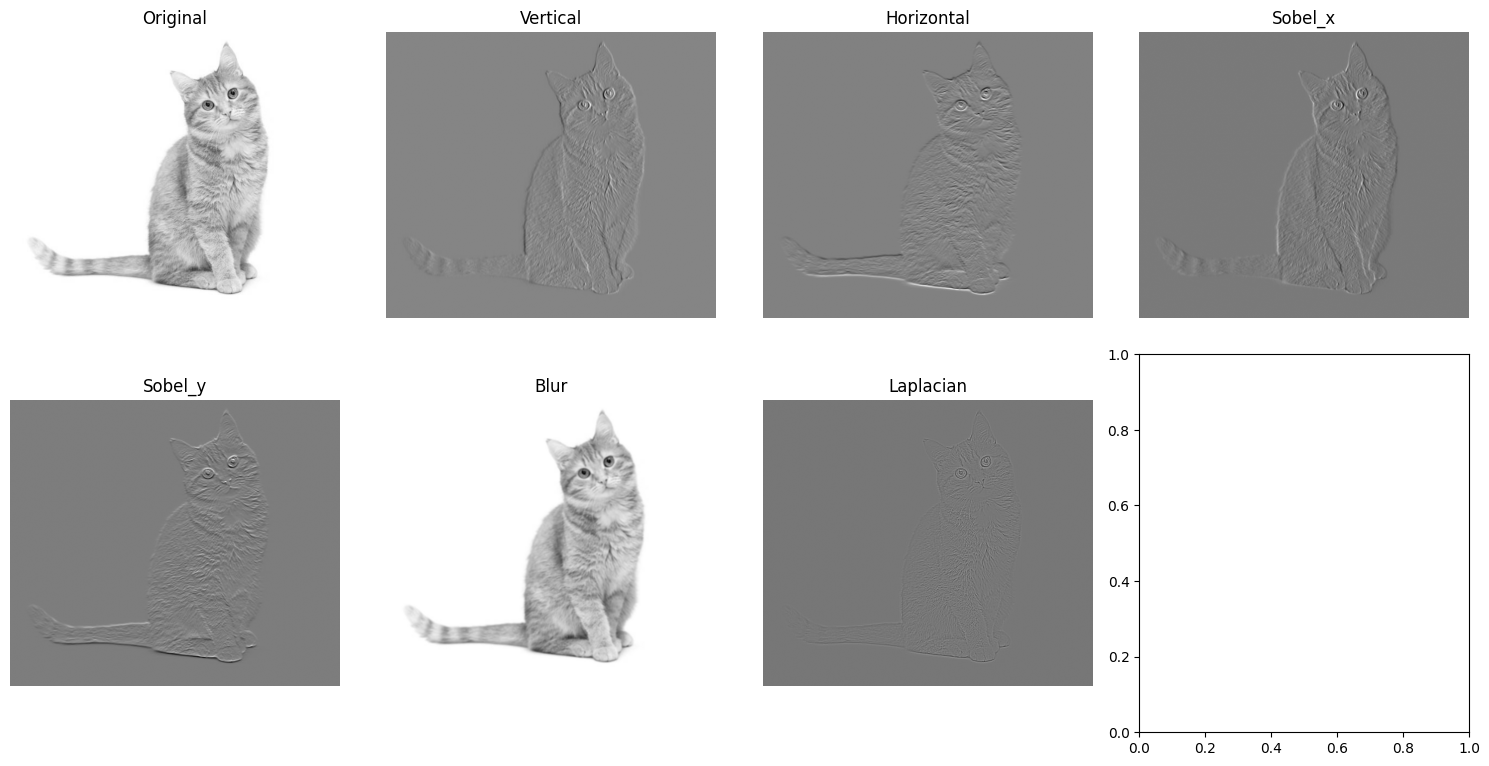

In [4]:
# 3pps
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.signal import convolve2d


# Predefined filters
filtros = {
    # Detects vertical edges
    "vertical": np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]),
    # Detects horizontal edges
    "horizontal": np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]),
    # Sobel X (enhanced vertical edges)
    "sobel_x": np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    # Sobel Y (enhanced horizontal edges)
    "sobel_y": np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    # Blur
    "blur": np.ones((3, 3)) / 9.0,
    # Edge detection (Laplacian)
    "laplacian": np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),
}

# Load image
image_pil = Image.open(
    "../../assets/course/topic_02_mathematics/cat_image.jpg"
).convert("L")
imagen = np.array(image_pil)

# Apply all filters
resultados = {}
for nombre, filtro in filtros.items():
    resultados[nombre] = convolve2d(imagen, filtro, mode="same", boundary="symm")

# Display results
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

# Original image
axes[0].imshow(imagen, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

# Filtered images
for i, (nombre, resultado) in enumerate(resultados.items(), 1):
    axes[i].imshow(resultado, cmap="gray")
    axes[i].set_title(nombre.capitalize())
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Filters like Sobel or Laplacian enhance abrupt intensity transitions, that is, edges.
Blur filters average local values, smoothing noise and fine details.

## Fundamental Components of Convolution

### Padding

_Padding_ adds rows and columns of zeros around the input image. Its main purpose is to
control the size of the output map and preserve information at the edges.

Without padding, the size is reduced. For example:

- Input: $5 \times 5$, Kernel: $3 \times 3$, Stride $= 1$  
  Output: $3 \times 3$

With `padding = 1`, the effective input becomes $7 \times 7$, so that:

- Extended input: $7 \times 7$, Kernel: $3 \times 3$, Stride $= 1$  
  Output: $5 \times 5$

In practice:

- `padding = 0`: Used when one wishes to progressively reduce spatial size.
- `padding = (kernel_size - 1) // 2`: Used to maintain the same input and output size
  when `stride = 1`.

### Stride

The _stride_ controls the displacement of the kernel over the image. A stride of 1
traverses all adjacent pixels; a larger stride skips positions, reducing the spatial
resolution of the output.

Examples (with padding $=0$):

- `stride = 1`: Input $8 \times 8$, Kernel $3 \times 3$ → Output $6 \times 6$.
- `stride = 2`: Input $8 \times 8$, Kernel $3 \times 3$ → Output $3 \times 3$.

Typical usage:

- `stride = 1`: Used to capture all spatial details.
- `stride = 2`: Used to reduce spatial size and computational cost, acting similarly to
  pooling.

### Kernel Size

The kernel size determines the local field of view of the convolution:

- Small kernel, such as $3 \times 3$: Most common, efficient, and sufficient in most
  modern architectures.
- Large kernel, such as $5 \times 5$ or $7 \times 7$: Covers more context in a single
  operation but introduces many more parameters.

It is more efficient to stack several $3 \times 3$ convolutions than to use a single
convolution with a large kernel. For example:

- A $5 \times 5$ layer uses $25$ parameters per channel.
- Two consecutive $3 \times 3$ layers use $18$ parameters per channel and achieve a
  similar or superior effective receptive field, while also introducing more
  nonlinearity.

## Pooling: Spatial Reduction

_Pooling_ reduces the spatial resolution of activation maps by aggregating information in
local regions. It is used to decrease the size of intermediate tensors, control
overfitting, and gain invariance to small translations.

### Max Pooling

Max pooling takes the maximum value within each region.

In [5]:
# 3pps
import numpy as np


def max_pool2d(image, pool_size=2):
    h, w = image.shape
    out_h, out_w = h // pool_size, w // pool_size
    output = np.zeros((out_h, out_w))

    for i in range(out_h):
        for j in range(out_w):
            region = image[
                i * pool_size : (i + 1) * pool_size, j * pool_size : (j + 1) * pool_size
            ]
            output[i, j] = np.max(region)

    return output


# Simple example with a 4x4 matrix
simple_image = np.array([[1, 2, 5, 6], [3, 4, 7, 8], [9, 10, 13, 14], [11, 12, 15, 16]])

print("Original image (4x4):")
print(simple_image)
print()

pooled = max_pool2d(simple_image, pool_size=2)

print("After max pooling (2x2):")
print(pooled)
print()

# Step by step explanation
print("Step by step:")
print(
    f"Top-left region: {simple_image[0:2, 0:2].flatten()} → max = {np.max(simple_image[0:2, 0:2])}"
)
print(
    f"Top-right region: {simple_image[0:2, 2:4].flatten()} → max = {np.max(simple_image[0:2, 2:4])}"
)
print(
    f"Bottom-left region: {simple_image[2:4, 0:2].flatten()} → max = {np.max(simple_image[2:4, 0:2])}"
)
print(
    f"Bottom-right region: {simple_image[2:4, 2:4].flatten()} → max = {np.max(simple_image[2:4, 2:4])}"
)

Original image (4x4):
[[ 1  2  5  6]
 [ 3  4  7  8]
 [ 9 10 13 14]
 [11 12 15 16]]

After max pooling (2x2):
[[ 4.  8.]
 [12. 16.]]

Step by step:
Top-left region: [1 2 3 4] → max = 4
Top-right region: [5 6 7 8] → max = 8
Bottom-left region: [ 9 10 11 12] → max = 12
Bottom-right region: [13 14 15 16] → max = 16


Max pooling preserves the strongest responses in each region, emphasizing the presence of
prominent features.

### Average Pooling

Average pooling calculates the average in each region, smoothing the information.

In [6]:
# 3pps
import numpy as np


def avg_pool2d(image, pool_size=2):
    h, w = image.shape
    out_h, out_w = h // pool_size, w // pool_size
    output = np.zeros((out_h, out_w))

    for i in range(out_h):
        for j in range(out_w):
            region = image[
                i * pool_size : (i + 1) * pool_size, j * pool_size : (j + 1) * pool_size
            ]
            output[i, j] = np.mean(region)

    return output


# Simple example with a 4x4 matrix
simple_image = np.array([[1, 2, 5, 6], [3, 4, 7, 8], [9, 10, 13, 14], [11, 12, 15, 16]])

print("Original image (4x4):")
print(simple_image)
print()

pooled = avg_pool2d(simple_image, pool_size=2)

print("After average pooling (2x2):")
print(pooled)
print()

# Step by step explanation
print("Step by step:")
print(
    f"Top-left region: {simple_image[0:2, 0:2].flatten()} → mean = {np.mean(simple_image[0:2, 0:2])}"
)
print(
    f"Top-right region: {simple_image[0:2, 2:4].flatten()} → mean = {np.mean(simple_image[0:2, 2:4])}"
)
print(
    f"Bottom-left region: {simple_image[2:4, 0:2].flatten()} → mean = {np.mean(simple_image[2:4, 0:2])}"
)
print(
    f"Bottom-right region: {simple_image[2:4, 2:4].flatten()} → mean = {np.mean(simple_image[2:4, 2:4])}"
)

Original image (4x4):
[[ 1  2  5  6]
 [ 3  4  7  8]
 [ 9 10 13 14]
 [11 12 15 16]]

After average pooling (2x2):
[[ 2.5  6.5]
 [10.5 14.5]]

Step by step:
Top-left region: [1 2 3 4] → mean = 2.5
Top-right region: [5 6 7 8] → mean = 6.5
Bottom-left region: [ 9 10 11 12] → mean = 10.5
Bottom-right region: [13 14 15 16] → mean = 14.5


Comparatively, max pooling is more aggressive and focused on prominent features, while
average pooling provides a more smoothed representation, which can be useful in tasks
where a more stable global response is desired.

## Types of Efficient Convolutions

In modern efficiency-oriented architectures, especially on mobile devices, variants of
standard convolution are used to drastically reduce the number of parameters and
computational cost.

### $1 \times 1$ Convolution (Pointwise)

The $1 \times 1$ convolution acts on each spatial position independently and only mixes
channels. It does not change the spatial size $(H, W)$, but it does change the number of
channels.

In [7]:
# 3pps
# In PyTorch
import torch.nn as nn


conv1x1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1)
# Input: (B, 64, H, W) → Output: (B, 32, H, W)

It is used to reduce or increase the number of channels (bottleneck blocks in ResNet, for
example) and to introduce nonlinearity between linear combinations of channels at very
low cost. The number of parameters is:

$$ \text{parameters} = 64 \times 32 \times 1 \times 1 = 2048. $$

### Depthwise Convolution

_Depthwise_ convolution applies one filter per channel independently, without mixing
them. In PyTorch, it is implemented using the `groups` parameter equal to the number of
channels.

In [8]:
depthwise = nn.Conv2d(
    in_channels=64,
    out_channels=64,  # Same number of channels
    kernel_size=3,
    padding=1,
    groups=64,  # One group per channel
)

In a standard $3 \times 3$ convolution from 64 to 64 channels, the number of parameters
would be:

$$ 64 \times 64 \times 3 \times 3 = 36{,}864. $$

In a depthwise convolution, only:

$$ 64 \times 3 \times 3 = 576. $$

This represents a massive cost reduction, although by itself it does not mix information
between channels.

### Depthwise-Separable Convolution

_Depthwise-separable_ convolution combines two steps:

1. Depthwise convolution: Spatially filters each channel independently.
2. Pointwise convolution ($1 \times 1$): Mixes channels and adjusts the number of output
   channels.

In [9]:
depthwise_separable = nn.Sequential(
    # Step 1: Depthwise (spatial filtering per channel)
    nn.Conv2d(64, 64, kernel_size=3, groups=64, padding=1),
    # Step 2: Pointwise (mix channels)
    nn.Conv2d(64, 128, kernel_size=1),
)

Overall, the number of parameters is approximately 8–9 times smaller than that of an
equivalent standard convolution, while maintaining competitive performance. This approach
is widely used in efficient architectures such as MobileNet and EfficientNet.

### Groupwise Convolution

_Groupwise_ convolution divides channels into several groups. Each group is processed
independently, but within each group channels are mixed.

In [10]:
groupwise = nn.Conv2d(
    in_channels=64,
    out_channels=128,
    kernel_size=3,
    padding=1,
    groups=4,  # Divides channels into 4 groups
)

In this case, each group processes 16 input channels and produces 32 output channels.
This technique allows balancing efficiency and modeling capacity and appears in
architectures such as ResNeXt and ShuffleNet.

## Implementation of Convolutional Blocks in PyTorch

In PyTorch, convolutional and pooling layers are typically combined with normalization
and activation functions to form basic blocks.

### Standard Convolutional Block

In [11]:
# 3pps
import torch.nn as nn


standard = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
)

This block applies a standard $3 \times 3$ convolution, normalizes activations with Batch
Normalization, and applies a ReLU activation function.

### Efficient Depthwise-Separable Block

In [12]:
efficient = nn.Sequential(
    # Depthwise
    nn.Conv2d(3, 3, kernel_size=3, groups=3, padding=1),
    nn.BatchNorm2d(3),
    nn.ReLU(inplace=True),
    # Pointwise
    nn.Conv2d(3, 64, kernel_size=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
)

# Pooling
pooling = nn.MaxPool2d(kernel_size=2, stride=2)

This block reduces computational cost while maintaining good representational power and
is complemented with a pooling layer to reduce spatial resolution.

### MobileNetV2-Type Block

MobileNetV2 uses inverted blocks with expansion and contraction of channels, combining
$1 \times 1$ and depthwise convolutions.

In [13]:
class MobileBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()

        # 1. Expansion (1x1 conv)
        self.expand = nn.Conv2d(in_ch, in_ch * 6, kernel_size=1)

        # 2. Depthwise (3x3)
        self.depthwise = nn.Conv2d(
            in_ch * 6,
            in_ch * 6,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_ch * 6,
        )

        # 3. Projection (1x1 conv)
        self.project = nn.Conv2d(in_ch * 6, out_ch, kernel_size=1)

    def forward(self, x):
        out = self.expand(x)
        out = self.depthwise(out)
        out = self.project(out)
        return out

This type of block allows building highly efficient deep networks on limited hardware.

## Comparison of Convolutions and Output Size Formula

For a 2D convolution with input size $\text{in\_size}$, kernel size $k$, padding $p$, and stride $s$, the unidimensional output size (per axis) is given by:

$$
\text{out\_size} = \left\lfloor \frac{\text{in\_size} + 2p - k}{s} \right\rfloor + 1
$$

Example:

- Input: $32$, Kernel: $3$, Padding: $1$, Stride: $1$  
  $$
  \text{out\_size} = \left\lfloor \frac{32 + 2 \times 1 - 3}{1} \right\rfloor + 1 = 32
  $$
  that is, spatial size is maintained.
